# OECD data

## Notes

### SSL issues

From January 2023 I got the error message: SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED. 
I gather the immediate issue is changes to the openSSL library. But the more significant issue is with the OECD website.

To fix this issue, I:

* created a text file named ~/ssl.conf with the following content:

        openssl_conf = openssl_init
    
        [openssl_init]
        ssl_conf = ssl_sect
    
        [ssl_sect]
        system_default = system_default_sect

        [system_default_sect]
        Options = UnsafeLegacyRenegotiation

* added this line to my .zshrc file (because I use zsh as my shell): 

        export OPENSSL_CONF=~/ssl.conf

## Python setup

### Imports

In [1]:
# system imports
import sys
from operator import ge, gt, le, lt
from pathlib import Path

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ABS
from abs_data_capture import (
    find_rows,
    get_ABS_meta_and_data,
    get_fs_constants,
    get_meta_constants,
    get_plot_constants,
    iudts_from_row,
)
from bis_data_capture import get_bis_cbpr
from henderson import hma
from matplotlib.lines import Line2D
from pandasdmx import Request

# local imports
from plotting import finalise_plot, set_chart_dir
from requests.exceptions import HTTPError

### Settings

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use("fivethirtyeight")

# multi-time-period charts
TODAY = pd.Timestamp("today")
RECENCY_PERIOD = 5  # years
MONTH_ADJ = 2  # months
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD, months=MONTH_ADJ)

# Other
SOURCE = "Source: OECD"

# Where to put the charts
CHART_DIR = "./CHARTS/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
set_chart_dir(CHART_DIR)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

# display charts in notebook
SHOW = False

## OECD support

### Data

In [3]:
location_map = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CHL": "Chile",
    "CZE": "Czech Rep.",
    "DNK": "Denmark",
    "EST": "Estonia",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JPN": "Japan",
    "KOR": "Korea",
    "LVA": "Latvia",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovak Rep.",
    "SVN": "Slovenia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Turkey",
    "GBR": "United Kingdom",
    "USA": "United States",
    "ARG": "Argentina",
    "BRA": "Brazil",
    "CHN": "China",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "IND": "India",
    "IDN": "Indonesia",
    "LTU": "Lithuania",
    "RUS": "Russia",
    "SAU": "Saudi Arabia",
    "ZAF": "South Africa",
}

In [4]:
chart_sets = {
    # Limit charts to 6 nations - otherwise they are too cluttered
    "of_interest": [
        "AUS",
        "USA",
        "CAN",
        "DEU",
        "GBR",
        "JPN",
    ],
    "anglosphere": [
        "AUS",
        "USA",
        "CAN",
        "NZL",
        "GBR",
        "IRL",
    ],
    "major_europe": [
        "FRA",
        "DEU",
        "ITA",
        "GBR",
        "RUS",
        "ESP",
    ],
    "largest_economies": [
        "USA",
        "CHN",
        "JPN",
        "DEU",
        "GBR",
        "IND",
    ],
    "asia": [
        "KOR",
        "JPN",
        "CHN",
        "IND",
        "IDN",
    ],
    "north_europe": [
        "DNK",
        "SWE",
        "NOR",
        "ISL",
        "FIN",
        "GBR",
    ],
    "baltic_europe": [
        "LVA",
        "LTU",
        "EST",
    ],
    "central_europe": [
        "CZE",
        "HUN",
        "SVK",
        "SVN",
        "POL",
        "GRC",
    ],
    "west_europe": [
        "ESP",
        "PRT",
        "NLD",
        "LUX",
        "FRA",
        "BEL",
    ],
    "italo_germanic_europe": [
        "DEU",
        "AUT",
        "CHE",
        "ITA",
    ],
    "turkey": [
        "TUR",
    ],  # a high inflation outlier.
    "n_america": [
        "USA",
        "CAN",
        "MEX",
    ],
    "c_s_america": [
        "CHL",
        "ARG",
        "BRA",
        "COL",
        "CRI",
    ],
    "other": [
        "AUS",
        "NZL",
        "SAU",
        "ZAF",
        "ISR",
    ],
}

### Python functions

In [5]:
def build_key(locations, subject, measure, frequency, start):
    if frequency:
        key = [locations, subject, measure, frequency]
    else:
        key = [locations, subject, measure]
    key_string = f"{'.'.join(['+'.join(x) for x in key])}" f"/all?startTime={start}"
    return key_string

In [6]:
# get the raw index data
def get_oecd_data(resource_id, key_string):
    oecd = Request("OECD")

    try:
        data = oecd.data(
            resource_id=resource_id,
            key=key_string,
        ).to_pandas()

    except HTTPError as err:
        print(f"HTTPError: {err}")
        data = pd.DataFrame()

    return data

In [7]:
def download_qtrly_data(resource_id, key_string):
    data = (
        get_oecd_data(resource_id=resource_id, key_string=key)
        .unstack()
        .T.dropna(how="all", axis="rows")
        .droplevel(axis=1, level=[1, 2, 3])
    )
    data.index = pd.PeriodIndex(data.index, freq="Q")

    return data

In [8]:
def annualise_percentages(series: pd.Series, periods: int = 12) -> pd.Series:
    """Annualise a growth rate for a period."""

    s = series / 100.0
    annual = (((1 + s) ** periods) - 1) * 100
    return annual

## OECD Unemployment Rates

### Get UE data

In [9]:
drop = ("ARG", "CHN", "IND", "SAU") # these states were problematics
uer_loc_map = location_map.copy()
for d in drop:
    uer_loc_map.pop(d)

In [10]:
# seasonally adjusted monthly unemployment rates
resource_id = "STLABOUR"  # Short-term labour
subject = "LRHUTTTT"  # Monthly unemployment rate all persons, sa
measure = "STSA"
rfooter = f"Source: OECD {resource_id} {subject} {measure}"

# capture monthly, then quaterly if no monthly data
uer = pd.DataFrame()
for period in ("M", "Q"): # Monthly must be first
    key = build_key(uer_loc_map, [subject], [measure], [period], "2020")
    data = (
        get_oecd_data(resource_id, key)
        .unstack()
        .T
        .dropna(how="all", axis="rows")
        .dropna(how="all", axis="columns")
        .droplevel(axis=1, level=[1, 2, 3])
    )
    data.index = pd.PeriodIndex(data.index, freq="M")
    transfer = list(set(data.columns.to_list()).difference(set(uer.columns.to_list())))
    uer[transfer] = data[transfer]

uer = uer.interpolate(method="time", limit_area="inside")
uer.tail()

,IRL,NLD,CHL,CZE,CAN,ESP,EST,KOR,BEL,JPN,COL,ITA,USA,GBR,AUT,POL,DNK,ISR,GRC,NOR,FRA,SVN,DEU,LUX,LTU,HUN,SVK,SWE,MEX,AUS,ISL,CRI,LVA,PRT,TUR,FIN,CHE,NZL
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-03,4.0,3.5,8.604463,2.6,5.0,12.5,5.9,2.7,5.6,2.8,10.066790,7.8,3.5,3.8,4.4,2.7,4.7,3.737435,11.4,3.7,7.0,3.6,3.0,4.9,7.6,3.8,6.1,7.2,2.719370,3.519330,3.3,9.655218,5.9,6.8,10.0,6.6,NaN,3.533333
2023-04,3.9,3.4,8.275608,2.7,5.0,12.1,6.2,2.6,5.6,2.6,10.308030,7.7,3.4,4.0,5.1,2.7,5.0,3.612877,11.2,3.5,7.0,3.6,3.0,4.9,7.5,3.8,6.1,7.1,2.942735,3.671465,3.2,10.064180,5.7,6.5,10.0,7.0,NaN,3.600000
2023-05,3.8,3.5,8.238752,2.5,5.2,11.9,6.7,2.5,5.7,2.6,10.118990,7.5,3.7,NaN,4.6,2.7,4.9,3.636805,11.3,3.1,7.1,3.6,3.0,5.0,7.2,3.9,6.0,7.2,2.978717,3.546576,3.2,9.560788,5.7,6.4,9.5,7.0,NaN,NaN
2023-06,3.8,3.5,NaN,2.7,5.4,11.7,6.6,2.6,5.7,2.5,9.390152,7.4,3.6,NaN,5.1,2.7,4.9,3.568945,11.1,3.4,7.1,3.5,3.0,5.1,7.5,3.9,6.0,7.9,2.666023,3.466603,NaN,NaN,5.7,6.4,NaN,7.1,NaN,NaN
2023-07,NaN,NaN,NaN,NaN,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot UR Rates 

In [11]:
for charset in chart_sets:
    chart_set = chart_sets[charset]
    endpoints = [f"{x}={uer[x].dropna().round(1).iloc[-1]}" 
                 for x in chart_set if x in uer.columns]
    lfooter=f"Latest: {', '.join(endpoints)}"

    ax = (
        uer[[x for x in chart_set if x in uer.columns]]
        .rename(columns=location_map)
        .sort_index(axis=1)
        .plot(lw=2.5)
    )
    finalise_plot(
        ax,
        title=f"Unemployment rates - {charset.replace('_', ' ').title()}",
        ylabel="Per cent",
        rfooter=rfooter,
        lfooter=lfooter,
        show=SHOW,
    )

In [12]:
# set a threshold for establishiong an OECD mean
print('Data available: \n', uer.notna().sum(axis=1).tail())
MIN_UER_REQUIREMENT = 33

Data available: 
 TIME_PERIOD
2023-03    37
2023-04    37
2023-05    35
2023-06    31
2023-07     2
Freq: M, dtype: int64


In [13]:
ax = uer.plot(lw=1, alpha=0.6)
ax.get_legend().remove()

mean_color, aus_color, lw = "black", "#dd0000", 3.5
uer_mean = uer.dropna(axis=0, thresh=MIN_UER_REQUIREMENT).mean(axis=1)
uer_mean.plot(lw=lw, color=mean_color, label="Mean")
uer["AUS"].plot(lw=lw, color=aus_color, label="Australia")
custom_lines = [
    Line2D([0], [0], color=mean_color, lw=lw),
    Line2D([0], [0], color=aus_color, lw=lw),
]
ax.legend(custom_lines, ["OECD monitored mean", "Australia"], fontsize="x-small")
finalise_plot(
    ax,
    title=f"Unemployment Rate Trajectories",
    xlabel=None,
    ylabel="Per cent",
    rfooter=rfooter,
    show=SHOW,
)

## OECD GDP data

### Real GDP growth

In [14]:
# rGDP - get the data
resource_id = "QNA"  # Quarterly National Accounts
measure = "VPVOBARSA"  # US dollars, volume estimates, fixed PPPs,
# OECD reference year, annual levels,
# seasonally adjusted
subject = "B1_GE"  # Gross domestic product - expenditure approach
rfooter = f"Source: OECD {resource_id} {subject} {measure}"
lfooter = "Volume est., US$, fixed PPPs, Seas Adj"

key = build_key(location_map, [subject], [measure], ["Q"], "1959")
rgdp = download_qtrly_data(resource_id, key)
rgdp_growth = rgdp.pct_change(1, fill_method=None) * 100

In [15]:
# diagnostics
rgdp_growth.shape

(258, 45)

In [16]:
# check for missing data in the final period ...
final_row = rgdp.iloc[-1]
missing_count = final_row.isna().sum()
if missing_count:
    print(f"Final period: {final_row.name}")
    print(f"Missing data count for final period: {missing_count}")
    print(f"Missing data belongs to: {rgdp.columns[final_row.isna()].to_list()}")
    print(f"Nations with final data: {rgdp.columns[final_row.notna()].to_list()}")

Final period: 2023Q2
Missing data count for final period: 17
Missing data belongs to: ['ARG', 'AUS', 'BRA', 'CHE', 'COL', 'GRC', 'IND', 'IRL', 'ISL', 'LUX', 'LVA', 'NOR', 'NZL', 'POL', 'RUS', 'TUR', 'ZAF']
Nations with final data: ['AUT', 'BEL', 'CAN', 'CHL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'HUN', 'IDN', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'MEX', 'NLD', 'PRT', 'SAU', 'SVK', 'SVN', 'SWE', 'USA']


In [17]:
# GDP identify/count quarterly contractions
contractions = rgdp_growth < 0
contraction_count = contractions.sum(axis=1)

start = pd.Period("1999Q1", freq="Q")
title = "Num. OECD Monitored States with Qrtly GDP contraction"
ax = contraction_count[contraction_count.index >= start].plot.bar()
ax.set_xticks(ax.get_xticks()[::4])
finalise_plot(
    ax,
    title=title,
    ylabel="Count",
    rfooter=rfooter,
    show=SHOW,
)

In [18]:
# List nations in contraction at last quarter
", ".join([location_map[x] for x in contractions.iloc[-1][contractions.iloc[-1]].index])

'Austria, Chile, Estonia, Hungary, Italy, Netherlands, Portugal, Saudi Arabia, Sweden'

In [19]:
# GDP identify/count recessions
recession = (rgdp_growth < 0) & (rgdp_growth.shift(1) < 0)
recession_count = recession.sum(axis=1)

title = "Number of OECD Monitored States in Recession"
ax = recession_count[recession_count.index >= start].plot.bar()
ax.set_xticks(ax.get_xticks()[::4])
finalise_plot(
    ax,
    title=title,
    ylabel="Count",
    rfooter=rfooter,
    lfooter="Recession defined as two quarters of negative GDP growth",
    show=SHOW,
)

In [20]:
# List nations in recession at last quarter
", ".join([location_map[x] for x in recession.iloc[-1][recession.iloc[-1]].index])

'Estonia, Hungary, Netherlands, Saudi Arabia'

In [21]:
if False:
    # GDP growth plots
    title = "GDP Growth: quarter on quarter"
    for label, locations in chart_sets.items():
        # get the data
        loc = [x for x in locations if x in rgdp_growth.columns]
        data = rgdp_growth[loc].rename(location_map, axis=1).sort_index(axis=1)

        # plot the data
        for start in None, RECENT:
            subset = (
                data
                if start is None
                else data[data.index >= pd.Period(start, freq="Q")]
            )
            ax = subset.plot(lw=2.5)
            ax.legend(title=None, loc="best", ncol=2)
            tag = label if start is None else f"{label}-recent"

            finalise_plot(
                ax,
                title=title,
                ylabel="Per cent",
                tag=tag,
                rfooter=rfooter,
                lfooter=lfooter,
                zero_y=True,
                show=SHOW,
            )

### Nominal GDP - national currency

In [22]:
# nGDP - get the data
resource_id = "QNA"  # Quarterly National Accounts
measure = "CQRSA"  # National currency, current prices, quarterly levels
subject = "B1_GE"  # Gross domestic product - expenditure approach
rfooter = f"Source: OECD {resource_id} {subject} {measure}"

key = build_key(location_map, [subject], [measure], ["Q"], "2000")
nGDP = download_qtrly_data(resource_id, key)
nGDP.tail()

LOCATION,ARG,AUS,AUT,BEL,BRA,CAN,CHE,CHL,COL,CRI,CZE,DEU,DNK,ESP,EST,FIN,FRA,GBR,GRC,HUN,IDN,IND,IRL,ISL,ISR,ITA,JPN,KOR,LTU,LUX,LVA,MEX,NLD,NOR,NZL,POL,PRT,RUS,SVK,SVN,SWE,TUR,USA,ZAF
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022Q2,18629314.7,612207.0,111276.0,136264.0,2473296.1,706044.0,192285.2,64310419.6,362537379.0,10989501.8,1674667.0,960361.0,711198.3,328513.0,8952.2,66678.0,654636.8,618210.0,51550.3,16298731.0,4894082.6,65490.0,126934.4,912239.2,438692.0,476624.8,139839650.0,543997600.0,16495.1,19676.1,9533.1,7082497.2,236920.8,1368055.0,94449.0,753487.4,59405.7,NaN,27101.6,14567.9,1477636.0,3573037.4,6312119.0,1655028.6
2022Q3,21974097.6,616783.0,113035.0,138915.0,2523237.3,701535.0,193697.0,66231271.3,377461386.4,11238801.2,1729092.0,969983.0,727398.3,334380.0,9120.6,67882.0,665289.1,627145.0,51887.6,17100861.0,4994080.8,67210.7,129313.9,975061.8,444423.0,476500.2,138678550.0,540608000.0,17256.3,20139.8,9833.8,7230832.0,242276.0,1480886.0,97627.0,783392.5,60207.0,NaN,27761.1,14989.6,1512221.0,4065474.7,6430985.3,1686922.5
2022Q4,26163039.3,630266.0,114648.7,139994.0,2562272.8,696247.0,194735.2,67694135.0,377616420.4,11368120.2,1743399.0,990946.0,710195.6,345771.0,9372.1,68401.0,673187.1,639616.0,53167.9,17549156.0,5102921.9,69003.0,130099.4,975458.4,455319.0,490770.5,140334900.0,541620600.0,17381.5,19104.0,10100.3,7322079.7,248039.2,1329291.0,96851.0,810414.3,61754.4,NaN,28481.4,15323.5,1526971.0,4562427.4,6534498.0,1676415.9
2023Q1,30804945.9,643563.0,117942.7,143351.0,2605987.3,703421.0,197346.0,69788387.9,392243865.6,11484232.5,1816647.0,1007966.0,707766.3,352547.0,9479.0,69729.0,685862.0,647110.0,53963.0,17716562.0,5160081.4,70703.5,127883.6,1016889.7,462466.0,502022.5,143551150.0,547219800.0,17823.4,20528.9,10344.8,7419002.8,253585.7,1317178.0,98427.0,837654.9,64399.0,NaN,29437.6,15879.4,1562971.0,5209452.1,6632443.5,1703175.3
2023Q2,NaN,NaN,120305.1,NaN,NaN,NaN,NaN,69138356.3,NaN,11543205.3,NaN,1027533.0,NaN,354313.0,NaN,NaN,702585.6,662100.0,NaN,NaN,5226086.4,NaN,NaN,NaN,468104.0,NaN,147675150.0,NaN,18058.4,NaN,NaN,NaN,257010.7,NaN,NaN,NaN,NaN,NaN,30149.8,16312.0,NaN,NaN,6708738.3,NaN


## OECD inflation data

### Functions

In [23]:
# download the CPI data - original series data - not seasonally adjusted ...
# becuase some nations do not seasonally adjust their data ...
def download_CPI_data(
    locations=location_map,
    start="1969",
    subject_tuple=("CP18ALTT", "CPALTT01"),
    measure="IXOB",
):
    combined = pd.DataFrame()

    q_locations = {
        "AUS",
        "NZL",
    }
    monthly = [x for x in locations if x not in q_locations]
    quarterly = [x for x in locations if x in q_locations]

    for locations, freq in zip((monthly, quarterly), ("M", "Q")):
        for subject in subject_tuple:
            if not len(locations):
                continue
            key = build_key(locations, [subject], [measure], freq, start)
            data = get_oecd_data(resource_id="PRICES_CPI", key_string=key)
            if not len(data):
                continue
            data = data.unstack().T.droplevel(axis=1, level=[1, 2, 3])
            data.index = pd.PeriodIndex(data.index, freq=freq)
            if freq == "Q":
                data = data.resample("M", convention="end").sum()
            combined = (
                data
                if not len(combined)
                else pd.concat([combined, data], axis=1, join="outer")
            ).sort_index()
            locations = [x for x in locations if x not in data.columns]

    # ignore last row when less than N data items
    N = 6
    combined = combined.dropna(thresh=N)
    combined = combined.rename(columns=location_map)

    return combined

### Calculate inflation rates

In [24]:
cpi = download_CPI_data()

HTTPError: 404 Client Error: No Results Found for url: https://stats.oecd.org/SDMX-JSON/data/PRICES_CPI/AUS+NZL.CP18ALTT.IXOB.Q/all?startTime=1969


In [25]:
# List of nations not reporting for the latest period
latest_period = cpi.index[-1]
print(f"Latest period: {latest_period}")
print(
    f"Missing CPI print: {', '.join(cpi.iloc[-1][cpi.iloc[-1].isna()].index.to_list())}"
)

Latest period: 2023-07
Missing CPI print: Japan, Austria, Brazil, Canada, China, Finland, France, United Kingdom, India, Ireland, Israel, Poland, Russia, Saudi Arabia, Slovak Rep., Sweden, Turkey, United States, South Africa, Australia, New Zealand


In [26]:
# raw inflation data
annual_inflation_raw = cpi.pct_change(12, fill_method=None) * 100
# The next step managers Au and NZ because they only have quarterly CPI data
annual_inflation = annual_inflation_raw.interpolate(method="time", limit_area="inside")
qrtly_inflation_raw = cpi.pct_change(3, fill_method=None) * 100
qrtly_inflation_annualised = annualise_percentages(qrtly_inflation_raw, 4).interpolate(
    method="time", limit_area="inside"
)

# smoothed / trend data
HENDERSON_TERM = 13
annual_inflation_smooth = pd.DataFrame(index=annual_inflation.index)
qrtly_inflation_annualised_smooth = pd.DataFrame(index=qrtly_inflation_annualised.index)
for nation in qrtly_inflation_annualised.columns:
    annual_inflation_smooth[nation] = hma(
        annual_inflation[nation].dropna(), HENDERSON_TERM
    )
    qrtly_inflation_annualised_smooth[nation] = hma(
        qrtly_inflation_annualised[nation].dropna(), HENDERSON_TERM
    )

# some useful constants
START_COVID = pd.Period("2020-01-01", freq="M")
HIGH_COVID = pd.Period("2021-01-01", freq="M")
linestyle = {
    "style": [
        "--.",
        "-.",
        "-",
        "--",
        ":",
    ]
    * 6
}
EXCLUDE = ["Turkey", "Russia"]  
# Turkey has rampant inflation
# Russie not updating data during war

# a quick look at Australia
qrtly_inflation_annualised["Australia"].tail(9)

TIME_PERIOD
2022-11    7.625303
2022-12    7.689137
2023-01    6.999181
2023-02    6.309224
2023-03    5.619268
2023-04    4.866109
2023-05    4.112951
2023-06    3.359793
2023-07         NaN
Freq: M, Name: Australia, dtype: float64

### CPI over the past year

In [27]:
# chart an inflation rate target
LOWER_IR, UPPER_IR = 2, 3
TARGET = {
    "ymin": LOWER_IR,
    "ymax": UPPER_IR,
    "color": "#dddddd",
    "label": f"{LOWER_IR}-{UPPER_IR}% inflation target",
    "zorder": -1,
}
TARGET_V = TARGET | {"xmin": LOWER_IR, "xmax": UPPER_IR}
for remove in ("ymin", "ymax"):
    TARGET_V.pop(remove)

In [28]:
def get_recent_ohlc(data: pd.DataFrame) -> pd.DataFrame:
    """For a dataset, build a table of Open, Highm Low, Close
    points for last valid 13 months in each column."""

    # compare progress over 13 months because Australia
    # and New Zealand only collect CPI measures quarterly
    INCLUSIVE_YEAR = 13  # months
    index = ["Open", "High", "Low", "Close"]
    summary = pd.DataFrame([], index=index)  # return vehicle
    for name in data.columns:
        if name in EXCLUDE:
            continue
        column = data[name]
        last_valid = column.last_valid_index()
        year = pd.period_range(end=last_valid, periods=INCLUSIVE_YEAR)
        frame = column[year]
        open = frame.iloc[0]
        high = frame.max()
        low = frame.min()
        close = frame.iloc[-1]
        key = f"{name} {str(last_valid.year)[2:]}-{last_valid.month:02d}"
        summary[key] = pd.Series([open, high, low, close], index=index)
    summary = summary.T.sort_values("Close")
    return summary

In [29]:
def plot_ohlc(ohlc_df: pd.DataFrame, horizontal: bool = True, **kwargs) -> None:
    """Plot data in ohlc_df in a open-high-low-close style."""

    def xy(x, y):
        return (x, y) if horizontal else (y, x)

    def set_limits(ax: plt.Axes) -> None:
        minimum = min(0, ohlc_df["Low"].min())  # include zero
        maximum = ohlc_df["High"].max()
        adjustment = (maximum - minimum) * 0.025
        limits = minimum - adjustment, maximum + adjustment
        if horizontal:
            ax.set_xlim(*limits)
        else:
            ax.set_ylim(*limits)

    # canvass
    fig, ax = plt.subplots()

    # sort out chart orientation
    good, bad = "darkblue", "darkorange"  # for colour blindness
    bar = ax.barh if horizontal else ax.bar
    reference = "left" if horizontal else "bottom"
    range = ohlc_df["High"] - ohlc_df["Low"]
    open_marker = "^" if horizontal else "<"
    close_marker = "v" if horizontal else ">"
    color = [
        good if open > close else bad
        for open, close in zip(ohlc_df.Open, ohlc_df.Close)
    ]

    # plot
    bar(
        ohlc_df.index,
        range,
        **{reference: ohlc_df["Low"]},
        color=color,
        linewidth=1.0,
        edgecolor="black",
        label="Range of prints through the 13 months",
        alpha=0.15,
    )
    ax.plot(
        *xy(ohlc_df["Open"], ohlc_df.index),
        marker=open_marker,
        linestyle="None",
        label="First print in the 13 months",
        color=good,
        markersize=5,
    )
    ax.plot(
        *xy(ohlc_df["Close"], ohlc_df.index),
        marker=close_marker,
        linestyle="None",
        label="Last print in the 13 months",
        color=bad,
        markersize=5,
    )
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    set_limits(ax=ax)
    if not horizontal:
        ax.set_xticklabels(ohlc_df.index, rotation=90)
    finalise_plot(ax, **kwargs)

In [30]:
def get_lim(df):
    adjust = (df["High"].max() - df["Low"].min()) * 0.02
    return min(0, df["Low"].min()) - adjust, df["High"].max() + adjust

In [31]:
selected = [
    "Australia",
    "Canada",
    "China",
    "France",
    "Germany",
    "India",
    "Indonesia",
    "Italy",
    "Japan",
    "Korea",
    "United Kingdom",
    "United States",
    "New Zealand",
    "Norway",
    "Sweden",
    "Brazil",
    "Spain",
]
summary = get_recent_ohlc(annual_inflation[selected])

title_aip = "Annual inflation prints over the most recent year"
lfooter = (
    "Year and month of latest print in the y-axis labels. "
    "Range is the 13 months up to and including the latest data. "
)
plot_ohlc(
    summary,
    horizontal=True,
    title=title_aip,
    xlim=get_lim(summary),
    zero_y=True,
    xlabel="Per cent per year",
    tag="shorter",
    ylabel=None,
    axvspan=TARGET_V,
    legend={"loc": "best", "fontsize": "xx-small"},
    rfooter=f"{SOURCE} CPI_PRICES",
    lfooter=lfooter,
    show=SHOW,
)

In [32]:
summary = get_recent_ohlc(annual_inflation_raw)

# plot that dataset
plot_ohlc(
    summary,
    horizontal=False,
    title=title_aip,
    ylabel="Per cent per year",
    ylim=get_lim(summary),
    tag="longer",
    xlabel=None,
    axhspan=TARGET,
    legend={"loc": "best", "fontsize": "xx-small"},
    rfooter=f"{SOURCE} CPI_PRICES",
    lfooter=lfooter,
    show=SHOW,
)

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_40097/49996124.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ohlc_df.index, rotation=90)


### Inflation trajectories

In [33]:
# months since annual inflation peak
HIGH_COVID = pd.Period("2021-01-01", freq="M")
results = pd.Series(dtype=int)
dataset = annual_inflation_raw[annual_inflation_raw.index >= HIGH_COVID]
also_exclude = EXCLUDE + ["Saudi Arabia"]
for nation in dataset.columns:
    if nation in also_exclude:
        continue
    series = dataset[nation]
    maximum = series.idxmax()
    last_valid = series.last_valid_index()
    elapsed = last_valid - maximum
    key = f"{nation} {str(last_valid.year)[2:]}-{last_valid.month:02}"
    results[key] = elapsed.n

# plot
results = results.iloc[np.lexsort([results.index, results.values])]
ax = results.plot.bar(width=0.8)
ax.tick_params(axis="both", which="major", labelsize="x-small")
finalise_plot(
    ax,
    title="Months since post-COVID annual inflation rate peak",
    xlabel=None,
    ylabel="Months",
    lfooter=(
        "Year and month of latest print in the y-axis labels. "
        # 'Using HMA trend data. '  # Only if using smoothed data
        f'Excluded: {", ".join(also_exclude)}. '
    ),
    rfooter=f"{SOURCE} CPI_PRICES",
    zero_y=True,
    show=SHOW,
)

In [34]:
# select >= 6 month since peak and starting below 3%
months, start = 6, 3

# smoothed or annual_inflation
series = annual_inflation

check = results[results >= months].index.to_list()
check = [c[:-months] for c in check]
check = [c for c in check if series.at[START_COVID, c] <= start]
print(check)
ax = series.loc[series.index >= START_COVID, check].plot(
    linewidth=2,
    **linestyle,
)
ax.legend()
finalise_plot(
    ax,
    title="Annual inflation trajectories selected nations",
    xlabel=None,
    ylabel="Per cent per year",
    tag="ahead-of-curve",
    axhspan=TARGET,
    legend={"ncols": 2, "loc": "best", "fontsize": "xx-small"},
    rfooter=f"{SOURCE} CPI_PRICES",
    lfooter=f"Selected on the basis that recent CPI peak >= {months} months ago. ",
    show=SHOW,
)

['Australia', 'Finland', 'Sweden', 'Ireland', 'United Kingdom', 'Belgium', 'Denmark', 'Germany', 'Italy', 'Norway', 'Portugal', 'Indonesia', 'Latvia', 'Lithuania', 'Netherlands', 'Costa Rica', 'Estonia', 'Switzerland', 'Canada', 'Korea', 'New Zealand', 'Slovenia', 'Spain', 'United States', 'Greece', 'Luxembourg']


In [50]:
# An anglosphere comparison
anglo = sorted([location_map[x] for x in chart_sets["anglosphere"]])

for data, tag, period in zip(
    [
        annual_inflation[anglo],
        annual_inflation_smooth[anglo],
        qrtly_inflation_annualised[anglo],
        qrtly_inflation_annualised_smooth[anglo],
    ],
    ["raw", "smooth", "raw", "smooth"],
    ["Annual", "Annual", "Quarterly annualised", "Quarterly annualised"],
):
    ax = data[data.index >= START_COVID].plot(
        linewidth=2,
        **linestyle,
    )
    lfooter = (
        f"{HENDERSON_TERM}-term Henderson moving averages. " if tag == "smooth" else ""
    )
    finalise_plot(
        ax,
        title=f"{period} inflation trajectories after COVID",
        xlabel=None,
        ylabel="Per cent per year",
        pre_tag=f"angloshpere-{tag}",
        axhspan=TARGET,
        legend={"ncols": 2, "loc": "best", "fontsize": "xx-small"},
        rfooter=f"{SOURCE} CPI_PRICES",
        lfooter=f"Anglosphere nations. {lfooter}",
        show=SHOW,
    )

### Selected individual nations

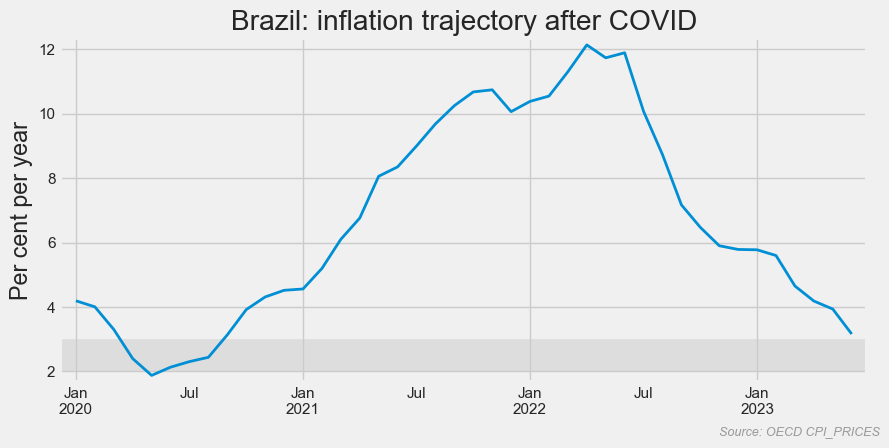

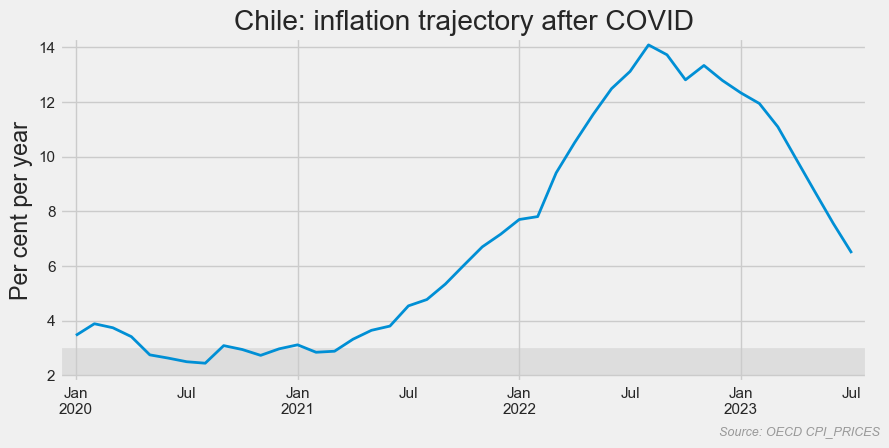

In [55]:
selected = ('Brazil', 'Chile')
for select in selected:
    data = annual_inflation[select]
    ax = data[data.index >= START_COVID].plot(
        linewidth=2,
    )
    finalise_plot(
        ax,
        title=f"{select}: inflation trajectory after COVID",
        xlabel=None,
        ylabel="Per cent per year",
        axhspan=TARGET,
        pre_tag='national-inflation-',
        rfooter=f"{SOURCE} CPI_PRICES",
        show=True,
    )

### Australia vs OECD monitored mean

In [36]:
# Pick a minimum number of data points before taking an OECD mean
# Note: Australia and NZ only report quarterly

for check in (2, 1):
    selected = annual_inflation.iloc[-check]
    print(f"Reporting at N-{check} (incl. excludeds): {len(selected.dropna())}")

print("Total nations after exclusions: "
      f"{len(annual_inflation.columns)-len(EXCLUDE)}")
n_minus_2 = annual_inflation.iloc[-2]
print("Missing at N-2 (including excludeds): "
      f"{n_minus_2[n_minus_2.isna()].index.to_list()}")

MIN_MEAN_REQUIRED = 38 # allow some wriggle room

Reporting at N-2 (incl. excludeds): 44
Reporting at N-1 (incl. excludeds): 24
Total nations after exclusions: 43
Missing at N-2 (including excludeds): ['Russia']


In [37]:
datasets = {
        "Annual": annual_inflation,
        "Trend annual": annual_inflation_smooth,
        "Quarterly-annualised": qrtly_inflation_annualised,
        "Trend Quarterly-annualised": qrtly_inflation_annualised_smooth,
}

for title, data in datasets.items():
    footer = (
        "" if "Trend" not in title else f"{HENDERSON_TERM}-term Henderson moving average. "
    )

    frame = data.drop(columns=EXCLUDE)
    frame = frame[frame.index >= START_COVID]
    ax = frame.plot(lw=1, alpha=0.6)
    ax.get_legend().remove()

    mean_color, aus_color, lw = "black", "#dd0000", 3.5
    mean = frame.dropna(axis=0, thresh=MIN_MEAN_REQUIRED).mean(axis=1)
    mean.plot(lw=lw, color=mean_color, label="Mean")

    frame["Australia"].plot(lw=lw, color=aus_color, label="Australia")
    custom_lines = [
        Line2D([0], [0], color=mean_color, lw=lw),
        Line2D([0], [0], color=aus_color, lw=lw),
    ]
    ax.legend(custom_lines, ["OECD monitored mean", "Australia"], fontsize="small")

    ax.axhline(0, lw=0.75, color="#777777")
    finalise_plot(
        ax,
        title=f"{title} CPI inflation trajectories",
        xlabel=None,
        ylabel="Per cent per year",
        tag="AU-v-OECD",
        lfooter=footer + f'All OECD monitored nations except: {", ".join(EXCLUDE)}',
        rfooter=f"{SOURCE} CPI_PRICES",
        show=SHOW,
    )

### Chart by latest inflation status

In [38]:
def on_target(x):
    return (le(x, UPPER_IR) & ge(x, LOWER_IR)), "near target"


def too_high(x):
    return gt(x, UPPER_IR), "too high"


def too_low(x):
    return lt(x, LOWER_IR), "too low"

In [39]:
for data, title, footer, tag in zip(
    (annual_inflation, qrtly_inflation_annualised, qrtly_inflation_annualised_smooth),
    ("Annual", "Quarterly-annualised", "Quarterly-annualised"),
    ("", "", f"{HENDERSON_TERM}-term Henderson moving average. "),
    ("annual", "qrtly", "qrtly-hma"),
):
    for comparator in (on_target, too_high, too_low):
        qx = data.drop(EXCLUDE, axis=1)
        renamer = {x: f"{x} ({(qx[x].ffill().iloc[-1]):0.1f}%)" for x in qx.columns}
        qx = qx.rename(columns=renamer)
        qx = qx[qx.index >= START_COVID]
        comparison, target_label = comparator(qx.ffill().iloc[-1])
        achievers = qx[qx.columns[comparison]].copy()

        ax = achievers.sort_index(axis=1).plot(
            linewidth=1,
            **linestyle,
        )

        ax.axhline(0, lw=0.75, color="#777777")
        oecd_mean = qx.dropna(axis=0, thresh=MIN_MEAN_REQUIRED).mean(axis=1)
        oecd_mean.plot(
            lw=3.5,
            color="black",
            label=f"OECD Monitored Mean ({oecd_mean.iloc[-1]:0.1f}%)",
        )

        finalise_plot(
            ax,
            title=f"{title} CPI growth {target_label}",
            xlabel=None,
            ylabel="Per cent per year",
            axhspan=TARGET,
            legend={"ncols": 3, "loc": "best", "fontsize": "xx-small"},
            tag=f"Au-vs-achievers-{tag}",
            lfooter=f"{footer}End points included in legend. Excludes: {', '.join(EXCLUDE)}",  # "
            rfooter=f"{SOURCE} CPI_PRICES",
            show=SHOW,
        )

### Bringing in ABS Monthly CPI indicator

In [40]:
catalogue_id = "6484"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)
abs_dict = get_ABS_meta_and_data(catalogue_id, verbose=False)
if abs_dict is None:
    sys.exit(-1)
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
Cache looks stale: Removing old cache version
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


In [41]:
for service_type in ("Seasonally Adjusted", "Original"):
    # get ABS Australia data
    rows = find_rows(
        meta,
        {
            service_type: type_col,
            "All groups CPI(, s| ;)": did_col,
            ";  Australia": did_col,
            "Index": did_col,
        },
        regex=True,
        exact=False,
        verbose=False,
    )
    assert len(rows) == 1
    row = rows.iloc[0]

    id, units, did, table, series_type = iudts_from_row(row)
    aus_cpi = abs_dict[table][id]
    aus_cpi_change = aus_cpi.pct_change(3) * 100
    aus_cpi_annualised = annualise_percentages(aus_cpi_change, 4).dropna()

    for treatment in None, "smoothed":
        if treatment:
            aus_data = hma(aus_cpi_annualised, HENDERSON_TERM)
        else:
            aus_data = aus_cpi_annualised.copy()
        aus_data = aus_data[aus_data.index >= START_COVID]
        print(
            f"Australia {service_type} {treatment} endpoint: {aus_data.iloc[-1]:0.2f}%"
        )

        # plot all
        if treatment:
            frame = qrtly_inflation_annualised_smooth.drop(
                columns=EXCLUDE + ["Australia"]
            )
        else:
            frame = qrtly_inflation_annualised.drop(columns=EXCLUDE + ["Australia"])
        frame = frame[frame.index >= START_COVID]
        ax = frame.plot(lw=1, alpha=0.6)
        ax.get_legend().remove()

        mean_color, aus_color, lw = "black", "#dd0000", 3.5
        mean = frame.dropna(axis=0, thresh=MIN_MEAN_REQUIRED).mean(axis=1)
        mean.plot(lw=lw, color=mean_color, label="Mean")

        aus_data.plot(lw=lw, color=aus_color)
        custom_lines = [
            Line2D([0], [0], color=mean_color, lw=lw),
            Line2D([0], [0], color=aus_color, lw=lw),
        ]
        ax.legend(
            custom_lines,
            [
                "OECD monitored mean",
                f"Australia (ABS monthly CPI {series_type.lower()} series)",
            ],
            fontsize="small",
        )

        ax.axhline(0, lw=0.75, color="#777777")
        tag2 = "" if not treatment else treatment
        footer = (
            f"{HENDERSON_TERM}-term Henderson moving averages over monthly. "
            if treatment
            else ""
        )
        finalise_plot(
            ax,
            title="Quarterly-annualised inflation - Australia (ABS) v OECD",
            xlabel=None,
            ylabel="Per cent per year",
            tag=f"Au-from-ABS-{service_type.replace(' ', '-')}-vs-OECD-{tag2}",
            lfooter=f'{footer}All OECD monitored nations except: {", ".join(EXCLUDE)}',
            rfooter=f"{SOURCE} CPI_PRICES. {source} T{table}",
            show=SHOW,
        )

/Users/bryanpalmer/ABS/notebooks/abs_data_capture.py:697: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  meta_select[column].str.contains(phrase, regex=regex)


Australia Seasonally Adjusted None endpoint: 3.06%
Australia Seasonally Adjusted smoothed endpoint: 2.64%


/Users/bryanpalmer/ABS/notebooks/abs_data_capture.py:697: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  meta_select[column].str.contains(phrase, regex=regex)


Australia Original None endpoint: 3.76%
Australia Original smoothed endpoint: 2.69%


### Latest CPI components

In [42]:
# set_up
all_items = ("CP18ALTT", "CPALTT01")
food = ("CP180100", "CP010000")
energy = ("CP18GREN", "CPGREN01")
points = {
    "All items": all_items,
    "Food and non-alcoholic beverages": food,
    "Energy": energy,
}
locations = list(location_map.keys())
start = TODAY.year - 2
measure = "IXOB"

In [43]:
def get_data_date(series):
    return str(pd.Period(series.last_valid_index(), freq="M"))


frame = pd.DataFrame()
loop_count = 0
for component, subjects in points.items():
    cpi_x = download_CPI_data(start=start, subject_tuple=subjects)
    inf_x = (
        cpi_x.pct_change(12, fill_method=None)  # Note: default fill_method is nasty
        * 100  # per cent
    )
    if not loop_count:
        latest_date = inf_x.apply(get_data_date)
        renamer = {x: f"{x} {str(latest_date[x])[2:]}" for x in inf_x.columns}
    latest = inf_x.ffill().iloc[-1].rename(renamer)
    if not loop_count:
        latest = latest.sort_values()
    frame[component] = latest
    loop_count += 1

# frame

HTTPError: 404 Client Error: No Results Found for url: https://stats.oecd.org/SDMX-JSON/data/PRICES_CPI/AUS+NZL.CP18ALTT.IXOB.Q/all?startTime=2021
HTTPError: 404 Client Error: No Results Found for url: https://stats.oecd.org/SDMX-JSON/data/PRICES_CPI/AUS+NZL.CP180100.IXOB.Q/all?startTime=2021
HTTPError: 404 Client Error: No Results Found for url: https://stats.oecd.org/SDMX-JSON/data/PRICES_CPI/AUS+NZL.CP18GREN.IXOB.Q/all?startTime=2021


In [44]:
# ... and plot
sns.set(font_scale=1)
ax = sns.scatterplot(frame)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    labels=labels,
    rotation=90,
)
ax.legend(loc="upper left")

finalise_plot(
    ax,
    title="Latest CPI growth - selected nations and items",
    ylabel="Per cent over year",
    rfooter=f"{SOURCE} CPI_PRICES",
    lfooter="Dates for latest headline (All items) data in YY-MM format",
    show=SHOW,
)

# tidy-up
plt.style.use("fivethirtyeight")

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_40097/1357312145.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


## Real interest rates

### Get Bank for International Settlements (BIS) Data

In [45]:
bis_meta, bis_data = get_bis_cbpr()

### Notional real interest rates

In [46]:
euro_zone = {
    "Austria",
    "Belgium",
    "Croatia",
    "Cyprus",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Portugal",
    "Slovakia",
    "Slovenia",
    "Spain",
}

recent = pd.Period("2005-01", freq="M")
inflation_r = annual_inflation[annual_inflation.index >= recent].copy()
inflation_r = inflation_r.rename(columns=location_map)
cb_policy = bis_data.resample(rule="M", kind="period").mean()
cb_policy = cb_policy[cb_policy.index >= recent]

for inf_nation in inflation_r.sort_index(axis=1):
    cbp_nation = inf_nation if inf_nation in cb_policy.columns else None
    if not cbp_nation and inf_nation in euro_zone:
        cbp_nation = "Euro area"
    if not cbp_nation:
        continue

    real_rates = cb_policy[cbp_nation] - inflation_r[inf_nation]
    ax = real_rates.plot(lw=2)
    ax.axhline(0, c="#555555", lw=0.5)
    title = f"Notional Real Interest Rates for {inf_nation}"
    finalise_plot(
        ax,
        title=title,
        ylabel="Rate (Per cent per year)",
        rfooter="Source: OECD, BIS",
        lfooter="Real Interest Rate = Central Bank Policy Rate - Inflation Rate. "
        "Expansionary policy < 0. Contractionary policy > 0.",
        show=SHOW,
    )

## Finished

In [47]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue Aug 22 2023 10:35:40

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

seaborn   : 0.12.2
matplotlib: 3.7.2
pandas    : 2.0.3
numpy     : 1.25.2
sys       : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:10:28) [Clang 15.0.7 ]

Watermark: 2.4.3



In [48]:
print("Done")

Done
